In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/heart-failure-prediction')
else:
    import zipfile,kaggle
    path = Path('heart-failure-prediction')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)


In [2]:

import pandas as pd

# CSV path provided by Kaggle when you add the dataset to your notebook
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")

# Show first few rows
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
modes = df.mode().iloc[0]

In [4]:
cats = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
conts = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
dep = 'HeartDisease'

def proc_data(df):
    df.fillna(modes, inplace=True)

    for i in cats:
        df[i] = pd.Categorical(df[i])

proc_data(df)

In [5]:
df.Sex.cat.codes.head()

0    1
1    0
2    1
3    0
4    1
dtype: int8

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


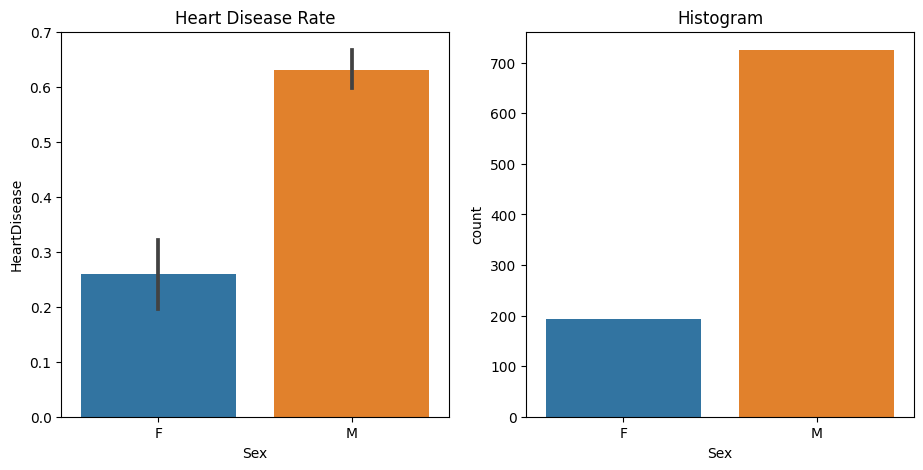

In [6]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Heart Disease Rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

Here we can see that if we make a binary split just based on gender, we would be able to predict heart disease with much better accuracy.

In [7]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x. cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

preds = val_xs.Sex==0

from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.6565217391304348

With this model, we achieve an mse of 0.657

Now, let's analyze what a split would look like on a continuous column. For example, take Age:

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


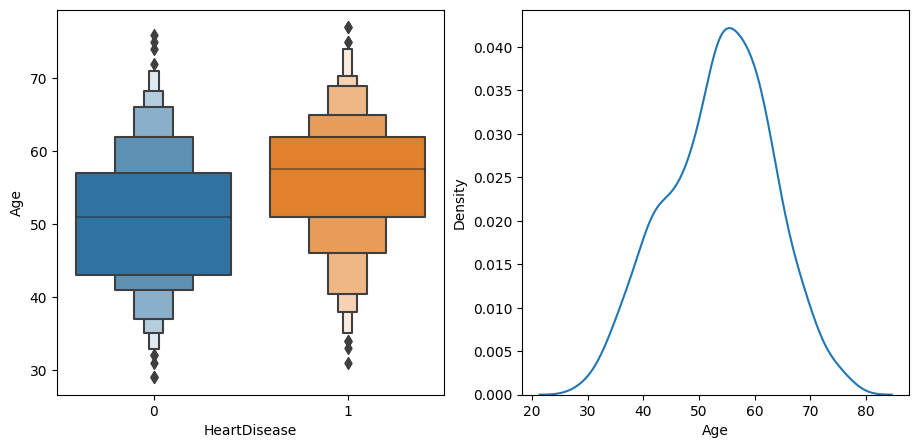

In [8]:
df_fare = trn_df[trn_df.Age>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="Age", ax=axs[0])
sns.kdeplot(data=df_fare, x="Age", ax=axs[1]);

This turns out even more accurate then 'sex' binary split, achieving an mse of 0.417.

In [9]:
preds = val_xs.Age>54
mean_absolute_error(val_y, preds)

0.41304347826086957

These functions score how good a binary split is by measuring the standard deviation of the dependent variable.

In [10]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

Here's the scores of the two previous splits:

In [11]:
print(score(trn_xs["Sex"], trn_y, 0.5))
print(score(trn_xs["Cholesterol"], trn_y, 0.5))

0.47372116597911734
0.4686772249455947


In [12]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak…

In [13]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngin…

This function calculates the best split given any category

In [14]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

Using this function, we can find the best possible splits over all columns, along with the best columns to split. As shown below, by splitting ST_SLOPE at 1, we can make the most accurate model (at least with one split)

In [15]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.47372116597911734),
 'ChestPainType': (0, 0.43456504663499457),
 'RestingECG': (1, 0.49611925240801863),
 'ExerciseAngina': (0, 0.42139665755253836),
 'ST_Slope': (1, 0.38610323380868145),
 'FastingBS': (0, 0.48095528818068733),
 'Age': (54, 0.4735318820170138),
 'RestingBP': (133, 0.4927881936826962),
 'Cholesterol': (126, 0.46844587982335745),
 'MaxHR': (132, 0.46267374100181347),
 'Oldpeak': (0.7, 0.446537571226993)}

In [16]:
preds = val_xs.ST_Slope<=1.5
mean_absolute_error(val_y, preds)

0.2

In order to create the best decision tree, we'll implement gini, a function similar to the score() used earlier which measured impurity.

In [17]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [18]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

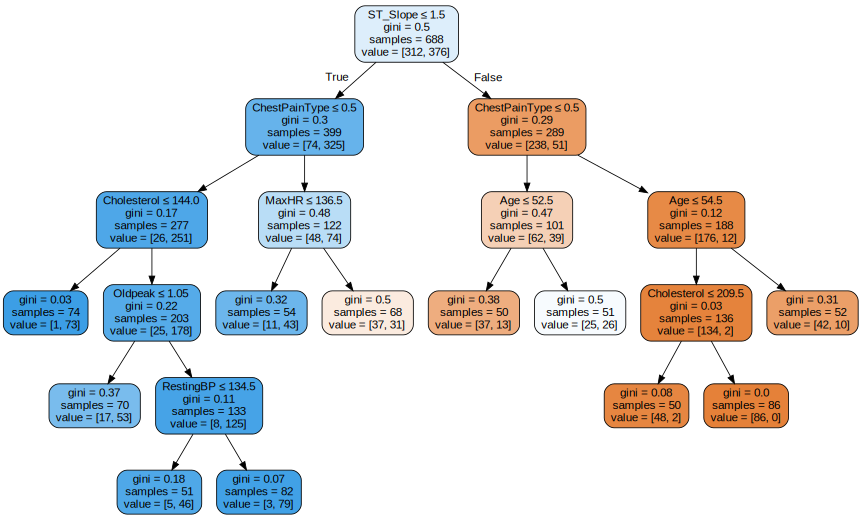

In [19]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

As we can see, this model is much more accurate then the OneR version.

In [20]:
mean_absolute_error(val_y, m.predict(val_xs))

0.17391304347826086

Now let's make a random forest model. First make a function to create a decision tree on a random part of the data, then iterate for the desired size of the random forest.

In [21]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

trees = [get_tree() for t in range(100)]

Then run the model:

In [22]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.20200000000000004

While the above code makes trees on random parts of the data, in order to make this a "true" random forest we must make each split take a random set of columns. To do this we can use sklearn's RandomForestClassifier:

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.12173913043478261

This returns a much more accurate model.